In [1]:
import sys
sys.path.append('..')

from scripts.data_loaders.common import show_sample
from scripts.data_loaders.TIMIT import TIMITDataset, SPEAKERS

import pandas as pd

from IPython.display import clear_output
clear_output()

In [2]:
speaker_info_df = pd.DataFrame.from_dict(SPEAKERS, orient='index')
speaker_info_df.head()

,SEX,DIALECT,SPLIT,RECORDING_DATE,BIRTH_DATE,HEIGHT,RACE,EDUCATION,COMMENTS
ABC0,M,New York City,TRN,03/03/86,06/17/60,"5'11""",WHT,BS,NaN
ABW0,M,Northern,TST,04/21/86,05/26/59,"5'9""",WHT,BS,NaN
ADC0,M,North Midland,TRN,02/25/86,04/27/54,"5'9""",WHT,HS,NaN
ADD0,M,Western,TRN,01/28/86,03/23/58,"6'2""",WHT,BS,NaN
ADG0,F,South Midland,TST,02/12/86,04/11/59,"5'4""",WHT,MS,NaN


In [3]:
train = TIMITDataset('train')
test = TIMITDataset('test')
print(f'Train size: {len(train)}')
print(f'Test size: {len(test)}')

Train size: 4620
Test size: 1680


IPA: doʊɾ̃æsmizɨkɪɹiɨnʔɔɪliɹæɡlaɪkðæth


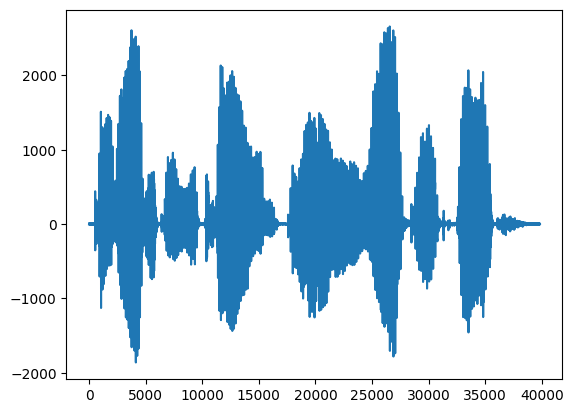

In [4]:
show_sample(train[0])